
# Network Analysis and Machine Learning - HW2

In this work, we aim to continue the analysis of LastFM - social network contains data about users and their connections with other users in Asia.
Our task is to predict the target (countries of nodes).

# Imports

In [133]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from networkx.algorithms import approximation
import json
import random
from sklearn.model_selection import train_test_split
from collections import Counter
from node2vec import Node2Vec
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


# Helpers

In [134]:
def plot_node_targets(nodes):
  """
  This function generates a bar plot to visualize the count of nodes in each target category. 
  Parameters
    nodes (pd.DataFrame): A DataFrame containing a column named 'target', which holds the target labels for the nodes.
  """
  count_targets = nodes['target'].value_counts().reset_index()
  count_targets.columns = ['target', 'count']
  plt.figure(figsize=(10, 6))
  sns.barplot(x='target', y='count', data=count_targets)
  plt.xlabel('Target')
  plt.ylabel('Count')
  plt.title('Count of Nodes in each Target')
  plt.show()

In [135]:
def metrics(y_true, y_pred, rf):
    """
    This function evaluates the performance of a classification model by printing a classification report and displaying a confusion matrix. 
    Parameters
        y_true (array-like): The true labels of the test data.
        y_pred (array-like): The predicted labels generated by the model.
        rf (classifier object): The trained classification model, used here to retrieve the class labels for the confusion matrix display.
    """
    print(classification_report(y_true, y_pred))
    cf_matrix = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(8,6), dpi=100)
    
    display = ConfusionMatrixDisplay(cf_matrix, display_labels=rf.classes_)
    
    ax.set(title='Confusion Matrix for the Target Classification Model')
    
    colors = plt.cm.get_cmap('Blues')
    display.plot(ax=ax, cmap=colors)

In [136]:
def run_experiment(X_train, X_test, grid_search, y_train, y_test, best_params = None, args = None):
    """
        Perform grid search for hyperparameter tuning on a Random Forest Classifier, train the model with the best parameters, and evaluate its performance.

        Parameters:
        X_train (array-like or sparse matrix): The training input samples.
        X_test (array-like or sparse matrix): The testing input samples.
        grid_search (GridSearchCV): The GridSearchCV object configured for hyperparameter tuning.
        y_train (array-like): The target values (class labels) for training.
        y_test (array-like): The target values (class labels) for testing.
    """
    if not best_params:
        grid_search.fit(X_train, y_train)
        best_params = grid_search.best_params_
        print("Best parameters found: ", best_params)
    if not args:
        p_bootstrap = best_params['bootstrap']
        p_max_depth = best_params['max_depth']
        p_max_features = best_params['max_features']
        p_min_samples_leaf = best_params['min_samples_leaf']
        p_min_samples_split = best_params['min_samples_split']
        p_n_estimators = best_params['n_estimators']
    else:
        p_bootstrap = args[0] if args[0] != None else best_params['bootstrap']  
        p_max_depth = args[1] if args[1] else best_params['max_depth']
        p_max_features = args[2] if args[2] else best_params['max_features']
        p_min_samples_leaf = args[3] if args[3] else best_params['min_samples_leaf']
        p_min_samples_split = args[4] if args[4] else best_params['min_samples_split']
        p_n_estimators = args[5] if args[5] else best_params['n_estimators']
        
    rf = RandomForestClassifier(bootstrap = p_bootstrap, max_depth = p_max_depth, max_features = p_max_features, 
                                min_samples_leaf = p_min_samples_leaf, min_samples_split = p_min_samples_split, n_estimators = p_n_estimators)
    
    rf.fit(X_train, y_train, sample_weight=None)
    y_pred = rf.predict(X_test)
    metrics(y_test, y_pred, rf)

# Pre Process
* Filtering nodes with degree less than 2.
* Extracting the artists that the nodes litensts to.


## Filtering

In [137]:
edges = pd.read_csv("/home/sitri/lastfm_asia_edges.csv")

In [138]:
nodes = pd.read_csv("/home/sitri/lastfm_asia_target.csv")

In [139]:
G = nx.Graph()
G = G.to_undirected()
edges_touples = edges.apply(lambda x: (x['node_1'], x['node_2']), axis=1)
G.add_edges_from(edges_touples)

In [140]:
small_degree_nodes = [node for node,degree in nx.degree(G) if degree < 2]
print(f"Number of nodes with degree less than 2: {len(small_degree_nodes)}")

Number of nodes with degree less than 2: 1754


In [141]:
G.remove_nodes_from(small_degree_nodes)

In [142]:
new_nodes = G.number_of_nodes()
print(f"Number of nodes after filtering nodes with degree less than 2: {new_nodes}")

Number of nodes after filtering nodes with degree less than 2: 5870


In [143]:
new_edges = G.number_of_edges()
print(f"Number of edges after filtering nodes with degree less than 2: {new_edges}")

Number of edges after filtering nodes with degree less than 2: 26052


In [144]:
# remove deleted node from nodes df
nodes = nodes[~nodes['id'].isin(small_degree_nodes)]
nodes.reset_index(drop=True, inplace=True)

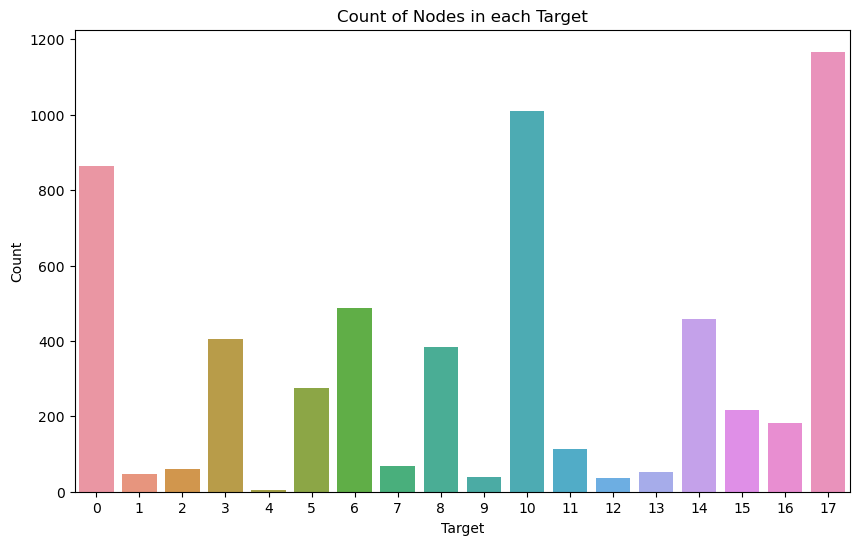

In [145]:
plot_node_targets(nodes)

From this plot, its notable that the classes are not evenly distributed.

In [146]:
file_path = '/home/sitri/lastfm_asia_features.json'

with open(file_path, "r") as file:
    json_data = json.load(file)


In [147]:
for node in small_degree_nodes:
  json_data.pop(str(node))

In [148]:
features_data = {}
target_data = {}

for key in json_data:
  features_data[int(key)] = json_data[str(key)][1:-1]
  target_data[int(key)] = nodes.loc[nodes['id'] == int(key)]['target'].values[0]

In [149]:
nx.set_node_attributes(G, target_data, 'target')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.3, random_state=42, stratify=y)

# Features Based on Artists

In [150]:
# Initialize an empty dictionary where each key represents an artist and the corresponding value represents the number of listeners
artists = {} 
# Initialize an empty dictionary where each key represents a node and the corresponding value is a list conatins all the artists the node listents to
artists_per_node = {}
for node in features_data:
  artists_per_node[node] = len(features_data[node])
  for artist in features_data[node]:
    if artist in artists:
      artists[artist] += 1
    else:
      artists[artist] = 1

In [151]:
artists = Counter(artists)

In [152]:
dict_values_list = list(artists_per_node.values())

In [153]:
print("The average number of listend artists per node : " + str(np.mean(dict_values_list)))
print("The max number of listend artists over nodes : " + str(np.max(dict_values_list)))
print("The min number of listend artists over nodes : " + str(np.min(dict_values_list)))


The average number of listend artists per node : 414.69982964224874
The max number of listend artists over nodes : 942
The min number of listend artists over nodes : 0


In [154]:
nodes['artists_per_node'] = nodes['id'].map(artists_per_node)

In [155]:
scaler = MinMaxScaler()
nodes['artists_per_node'] = scaler.fit_transform(nodes['artists_per_node'].values.reshape(-1, 1))

In [156]:
top_artists = artists.most_common(1000)

In [157]:
# Initialize one-hot representation with a dict. Every key is an artists. The corresponding value is a list where the i-th element represent the i-th node (index). The value of the
# i-th element is 0 if the i-th node not listent to this artist, 1 otherwise.
one_hot = {}
for artists, listners in top_artists:
  one_hot[artists] = []
for node in features_data:
  for artist, listners in top_artists:
    if artist in features_data[node]:
      one_hot[artist].append(1)
    else:
      one_hot[artist].append(0)

In [158]:
one_hot_artists = pd.DataFrame(one_hot)

In [159]:
nodes = pd.concat([nodes, one_hot_artists], axis=1)

In [160]:
nodes_artists = pd.concat([nodes['id'], nodes['artists_per_node'], one_hot_artists], axis=1)
nodes_artists.columns = nodes_artists.columns.astype(str)

# Features Based on Network Architecture

## Degree Centerality

In [161]:
degree_centrality = nx.degree_centrality(G)
nx.set_node_attributes(G, degree_centrality, 'degree_centrality')

In [162]:
nodes['degree_centrality'] = nodes['id'].map(degree_centrality)

## Eigenvector Centrality

In [163]:
eigenvector_centrality = nx.eigenvector_centrality(G)
nx.set_node_attributes(G, eigenvector_centrality, 'eigenvector_centrality')

In [164]:
nodes['eigenvector_centrality'] = nodes['id'].map(eigenvector_centrality)

## Comuunity Detection

In [165]:
# class is a file contain for each node its community
modularity_gephi = pd.read_csv('/home/sitri/class.csv')
modularity_gephi = modularity_gephi.sort_values(by='id')
modularity_gephi = modularity_gephi.reset_index()
nodes['class'] = modularity_gephi['class']

In [166]:
nodes_arch = nodes[['id', 'degree_centrality', 'eigenvector_centrality', 'class']]

# Features Based on Target

In [167]:
targets = sorted(list(nodes['target'].unique()))

In [168]:
# Initiate dict with empty lists
neighbor_target = {}
for target in targets:
  neighbor_target[target] = []

In [169]:
# Itearate all the nodes in training data
counter = 0
train_nodes = list(nodes.iloc[X_train.index]['id'])
for node in G.nodes():
  total_n = 0
  # initiate empty counter for all target
  target_counter = [0] * len(targets)
  # get node neighbours
  node_neigh = G.neighbors(node)
  for n in node_neigh:
    # itearte only the neighbours in training data
    if n not in train_nodes:
      continue
    # get target of neighbour
    target = G.nodes[n]['target']
    # append 1 to target which represent the number of neighbours from this target
    target_counter[target] += 1
    total_n += 1
  # to probability
  for i in range(len(target_counter)):
    if total_n == 0:
      # if there is no neighibors (in training data), all the vtarget value get 0
      target_counter[i] = 0
      neighbor_target[targets[i]].append(0)
    else:
      target_counter[i] = target_counter[i] / total_n
      neighbor_target[targets[i]].append(target_counter[i])

In [170]:
neighbor_target_df = pd.DataFrame(neighbor_target)

In [171]:
neighbor_target_df.columns = neighbor_target_df.columns.astype(str)

In [172]:
top_artists = top_artists[:200]

In [173]:
top_200_prec_counter = {}
for artist, listners in top_artists:
    top_200_prec_counter[artist] = {target : [] for target in range(len(targets))}

In [174]:
# Itearate all the nodes in training data
counter = 0
for node in G.nodes():
  total_n = 0
  # initiate empty counter for all top artists
  artist_counter = {art: [0] * len(targets) for art, listners in top_artists}
  # get node neighbours
  node_neigh = G.neighbors(node)
  for n in node_neigh:
    total_n += 1
    if n not in train_nodes:
      continue
    # get node target
    target = G.nodes[n]['target']
    # get node artists
    artists = features_data[n]
    # itearate all the 200 top artists
    for art in artists:
      # if neighbours listent to the artist
      if art in artist_counter:
        artist_counter[art][target] += 1
    
  # to probability
  if total_n == 0:
    for artist in artist_counter: # artist_counter.keys = top_200_prec_counter
        for target in top_200_prec_counter[artist]:
          target.append(0)
  else:
    for artists in artist_counter:
        for target in range(len(targets)):
          prob = artist_counter[artists][target] / total_n
          top_200_prec_counter[artists][target].append(prob)


In [175]:
artist_target = {}
for artists in top_200_prec_counter:
    for target in top_200_prec_counter[artists]:
        key = f"{artists}_{target}"
        artist_target[key] = top_200_prec_counter[artists][target]


In [176]:
artist_target_df = pd.DataFrame(artist_target)

In [177]:
nodes = pd.concat([nodes, neighbor_target_df, artist_target_df], axis=1)

In [178]:
nodes_target_df = pd.concat([nodes['id'], neighbor_target_df, artist_target_df], axis=1)

In [179]:
artist_target_df.columns = artist_target_df.columns.astype(str)

# Split

In [180]:
X_full = nodes[nodes.columns[2:]]
y = nodes['target']
X_full.columns = X_full.columns.astype(str)
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.3, random_state=42, stratify=y)

# Model Evaluation

## Check Each Feature Set

In [109]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

In [110]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

### 1. Artists Features

In [182]:
art_cols = nodes_artists.columns[1:]
X_train_art = X_train[art_cols]
X_test_art = X_test[art_cols]

In [ ]:
params = {'bootstrap': False, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
run_experiment(X_train_art, X_test_art, grid_search, y_train, y_test, best_params=params)

### 2. Architecture Features

In [183]:
nodes_arch_cols = nodes_arch.columns[1:]
X_train_arc = X_train[nodes_arch_cols]
X_test_arc = X_test[nodes_arch_cols]

In [ ]:
run_experiment(X_train_arc, X_test_arc, grid_search, y_train, y_test)

### Target Features

#### 3. Based on Target Only

In [184]:
nodes_target_only_cols = neighbor_target_df.columns

X_train_target_only = X_train[nodes_target_only_cols]
X_test_target_only = X_test[nodes_target_only_cols]

In [ ]:
run_experiment(X_train_target_only, X_test_target_only, grid_search, y_train, y_test)

#### 4. Based on Target-Artists

In [185]:
target_artists_cols = artist_target_df.columns
X_train_target_artists = X_train[target_artists_cols]
X_test_target_artists = X_test[target_artists_cols]

In [ ]:
p_ta = {'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
run_experiment(X_train_target_artists, X_test_target_artists, grid_search, y_train, y_test, best_params=p_ta)

#### 5. Combination - Target Features 1 & 2

In [186]:
target_cols = nodes_target_df.columns[1:]
X_train_target = X_train[target_cols]
X_test_target = X_test[target_cols]

In [ ]:
pt = {'bootstrap': False, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
run_experiment(X_train_target, X_test_target, grid_search, y_train, y_test, best_params=pt)

## 6. Node2Vec

In [52]:
params = {
    'dimensions' : {10, 100},
    'walk_length': {3, 12},
    'num_walks' : {100, 200}
}

In [ ]:
vectors = {}

for dim in params['dimensions']:
    for length in params['walk_length']:
        for walks in params['num_walks']:
            key = f"{dim}_{length}_{walks}"     
            node2vec = Node2Vec(G, dimensions=dim, walk_length=length, num_walks=walks, workers=6)
            vectors[key] = node2vec.fit(window=10, min_count=1)

In [ ]:
best_params = {}
for vector in vectors:
    print(vector)
    model = vectors[vector]
    vector_list = {}
    for node in G.nodes():
        node_embed = model.wv.get_vector(str(node))
        vector_list[node] = np.array(node_embed)
    df_embed = pd.DataFrame(vector_list)
    df_embed = df_embed.T
    df_embed.reset_index(inplace=True)
    df_embed.columns = ['id'] + [f'dim_{i}' for i in range(1, df_embed.shape[1])]
    X_train_embed = df_embed.loc[df_embed['id'].isin(train_nodes)].drop(['id'], axis = 1)
    X_test_embed = df_embed.loc[~df_embed['id'].isin(train_nodes)].drop(['id'], axis = 1)
    run_experiment(X_train_embed, X_test_embed, grid_search, y_train, y_test)

## Check Combinations Feature Set

### 7. Artists & Architecture

In [140]:
param_grid_art_arc = {
    'n_estimators': [100, 300],
    'min_samples_leaf': [1, 4],
    'min_samples_split': [2, 5],
    'bootstrap' : [True, False]
}
args = [None, 10, 'log2', None, None, None]

In [141]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_art_arc = GridSearchCV(estimator=rf, param_grid=param_grid_art_arc, 
                           cv=5, n_jobs=-1, verbose=2)

In [187]:
X_train_art_arc = pd.concat([X_train_art, X_train_arc] ,axis = 1)
X_test_art_arc = pd.concat([X_test_art, X_test_arc] ,axis = 1)


In [ ]:
run_experiment(X_train_art_arc, X_test_art_arc, grid_search_art_arc, y_train, y_test, args = args)

### 8. Artists & Target (1)

In [158]:
param_grid_art_target_1 = {
    'min_samples_split' : [2, 5],
    'bootstrap' : [True, False],
    'max_depth' : [10, 30]
}
args_art_target_1 = [None, None, 'log2', 4, None, 100]

In [159]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_art_target1 = GridSearchCV(estimator=rf, param_grid=param_grid_art_target_1, 
                           cv=5, n_jobs=-1, verbose=2)

In [188]:
X_train_art_target_1 = pd.concat([X_train_art, X_train_target_only] ,axis = 1)
X_test_art_target_1 = pd.concat([X_test_art, X_test_target_only] ,axis = 1)


In [ ]:
run_experiment(X_train_art_target_1, X_test_art_target_1, grid_search_art_target1, y_train, y_test, args = args_art_target_1)

### 9. Artists & Target (2)

In [161]:
param_grid_art_target_2 = {
    'n_estimators': [100, 300],
    'min_samples_leaf': [2, 5],
    'min_samples_split' : [2, 4],
    'bootstrap' : [True, False]
}
args_art_target_2 = [None, 10, 'log2', None, None, None]

In [162]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_art_target2 = GridSearchCV(estimator=rf, param_grid=param_grid_art_target_2, 
                           cv=5, n_jobs=-1, verbose=2)

In [189]:
X_train_art_target_2 = pd.concat([X_train_art, X_train_target_artists] ,axis = 1)
X_test_art_target_2 = pd.concat([X_test_art, X_test_target_artists] ,axis = 1)


In [ ]:
param_art_target_2 = {'bootstrap': True, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 300}
run_experiment(X_train_art_target_2, X_test_art_target_2, grid_search_art_target2, y_train, y_test, args = args_art_target_2, best_params=param_art_target_2)

### 10. Artists & Target (1 & 2)

In [128]:
param_grid_art_target = {
    'min_samples_leaf': [1, 4],
    'min_samples_split' : [2, 10],
}
args_art_target = [False, 10, 'log2', None, None, 100]

In [129]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_art_target = GridSearchCV(estimator=rf, param_grid=param_grid_art_target, 
                           cv=5, n_jobs=-1, verbose=2)

In [190]:
X_train_art_target = pd.concat([X_train_art, X_train_target] ,axis = 1)
X_test_art_target = pd.concat([X_test_art, X_test_target] ,axis = 1)


In [ ]:
params = {'bootstrap': True, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 300}
run_experiment(X_train_art_target, X_test_art_target, grid_search_art_target, y_train, y_test, args = args_art_target, best_params=params)

### 11. Architecture & Target (1)

In [166]:
param_grid_arc_target1 = {
    'min_samples_leaf': [1, 4],
    'n_estimators' : [100, 300],
    'bootstrap' : [True, False],
    'max_depth': [10, 30]
}
args_art_arc_target= [None, None, 'log2', None, 5, None]

In [167]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_arc_target1 = GridSearchCV(estimator=rf, param_grid=param_grid_arc_target1, 
                           cv=5, n_jobs=-1, verbose=2)

In [191]:
X_train_arc_target_1 = pd.concat([X_train_arc, X_train_target_only] ,axis = 1)
X_test_arc_target_1 = pd.concat([X_test_arc, X_test_target_only] ,axis = 1)


In [ ]:
run_experiment(X_train_arc_target_1, X_test_arc_target_1, grid_search_arc_target1, y_train, y_test, args = args_art_arc_target)

### 12. Architecture & Target (2)

In [169]:
param_grid_arc_target2 = {
    'min_samples_leaf': [1, 2],
    'n_estimators': [200, 300],
}
args_art_arc_target2= [True, 10, 'log2', None, 5, None]


In [170]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_arc_target2 = GridSearchCV(estimator=rf, param_grid=param_grid_arc_target2, 
                           cv=5, n_jobs=-1, verbose=2)

In [192]:
X_train_arc_target_2 = pd.concat([X_train_arc, X_train_target_artists] ,axis = 1)
X_test_arc_target_2 = pd.concat([X_test_arc, X_test_target_artists] ,axis = 1)


In [ ]:
run_experiment(X_train_arc_target_2, X_test_arc_target_2, grid_search_arc_target2, y_train, y_test, args = args_art_arc_target2)

### 13. Architecture & Target (1 & 2)

In [172]:
param_grid_arc_target = {
    'n_estimators': [100, 300],
    'min_samples_split' : [5, 10],
    'bootstrap' : [True, False]
}
args_arc_target= [None, 10, 'log2', 1, None, None]

In [173]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_arc_target = GridSearchCV(estimator=rf, param_grid=param_grid_arc_target, 
                           cv=5, n_jobs=-1, verbose=2)

In [193]:
X_train_arc_target = pd.concat([X_train_arc, X_train_target] ,axis = 1)
X_test_arc_target = pd.concat([X_test_arc, X_test_target] ,axis = 1)

In [ ]:
run_experiment(X_train_arc_target, X_test_arc_target, grid_search_arc_target, y_train, y_test, args=args_arc_target)

### 14. Artists & Architecture & Target (1)

In [175]:
param_grid_art_arc_target_1 = {
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5],
    'max_depth': [10, 30]
}
args_art_arc_target_1= [False, None, 'log2', None, None, 300]


In [176]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_art_arc_target_1 = GridSearchCV(estimator=rf, param_grid=param_grid_art_arc_target_1, 
                           cv=5, n_jobs=-1, verbose=2)

In [194]:
X_train_art_arc_target1 = pd.concat([X_train_art, X_train_arc, X_train_target_only] ,axis = 1)
X_test_art_arc_target1 = pd.concat([X_test_art, X_test_arc, X_test_target_only] ,axis = 1)

In [ ]:
run_experiment(X_train_art_arc_target1, X_test_art_arc_target1, grid_search_art_arc_target_1, y_train, y_test, args = args_art_arc_target_1)

### 15. Artists & Architecture & Target (2)

In [178]:
param_grid_art_arc_target_2 = {
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 5],
    'bootstrap' : [True, False],
    'n_estimators': [200, 300]
}
args_art_arc_target_2= [None, 10, 'log2', None, None, None]

In [179]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_art_arc_target_2 = GridSearchCV(estimator=rf, param_grid=param_grid_art_arc_target_2, 
                           cv=5, n_jobs=-1, verbose=2)

In [195]:
X_train_art_arc_target2 = pd.concat([X_train_art, X_train_arc, X_train_target_artists] ,axis = 1)
X_test_art_arc_target2 = pd.concat([X_test_art, X_test_arc, X_test_target_artists] ,axis = 1)

In [ ]:
run_experiment(X_train_art_arc_target2, X_test_art_arc_target2, grid_search_art_arc_target_2, y_train, y_test, args=args_art_arc_target_2)

### 16. Artists & Architecture & Target (1 & 2)

In [181]:
param_grid_art_arc_target = {
    'n_estimators': [100, 300],
    'min_samples_leaf': [1, 4, 5],
    'min_samples_split' : [2, 5, 10],
    'bootstrap': [False, True]
}
args_art_arc_target= [None, 10, 'log2', None, None, None]

In [182]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_art_arc_target = GridSearchCV(estimator=rf, param_grid=param_grid_art_target, 
                           cv=5, n_jobs=-1, verbose=2)

In [196]:
X_train_art_arc_target = pd.concat([X_train_art, X_train_arc, X_train_target] ,axis = 1)
X_test_art_arc_target = pd.concat([X_test_art, X_test_arc, X_test_target] ,axis = 1)

In [ ]:
params = {'bootstrap': False, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
run_experiment(X_train, X_test, grid_search, y_train, y_test, best_params=params)

### Node2Vec Combinations

In [ ]:
node2vec_best_model = Node2Vec(G, dimensions=100, walk_length=3, num_walks=100, workers=6)
node2vec_best_model = node2vec_best_model.fit(window=10, min_count=1)

In [199]:
vector_list = {f'dim_{i}' : [] for i in range(100)}
vector_list['id'] = []

In [200]:
for node in G.nodes():
    node_embed = node2vec_best_model.wv.get_vector(str(node))
    vector_list['id'].append(node)
    for i in range(len(node_embed)):
        vector_list[f'dim_{i}'] = node_embed[i]
df_embed = pd.DataFrame(vector_list)

In [201]:
merged_nodes = pd.merge(nodes, df_embed, on='id')

In [202]:
merged_nodes.columns = merged_nodes.columns.astype(str)

In [203]:
X_train_merged, X_test_merged, y_train_merged, y_test_merged = train_test_split(merged_nodes, y, test_size=0.3, random_state=42, stratify=y)

#### 17. Artists & Node2Vec

In [204]:
art_cols = nodes_artists.columns[1:].append(df_embed.columns[:-1])
X_train_art_node = X_train_merged[art_cols]
X_test_art_node = X_test_merged[art_cols]

In [312]:
param_grid_art_node = {
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
}
args_art_node = [None, 10, None, 4, 2, 100]

In [313]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_art_node = GridSearchCV(estimator=rf, param_grid=param_grid_art_node, 
                           cv=5, n_jobs=-1, verbose=2)

In [ ]:
run_experiment(X_train_art_node, X_test_art_node, grid_search_art_node, y_train, y_test, args = args_art_node)

#### 18. Architecture & Node2Vec

In [205]:
nodes_arch_cols = nodes_arch.columns[1:].append(df_embed.columns[:-1])
X_train_arc_node = X_train_merged[nodes_arch_cols]
X_test_arc_node = X_test_merged[nodes_arch_cols]

In [316]:
param_grid_arc_node = {
    'min_samples_leaf': [1, 4],
    'n_estimators' : [300, 100],
    'max_features': ['log2', 'sqrt'],
    'min_samples_split' : [2, 5]
}
args_arc_node = [True, 10, None, None, None, None]


In [317]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_arc_node = GridSearchCV(estimator=rf, param_grid=param_grid_arc_node, 
                           cv=5, n_jobs=-1, verbose=2)

In [ ]:
run_experiment(X_train_arc_node, X_test_arc_node, grid_search_arc_node, y_train, y_test, args = args_arc_node)

#### 19. Target 1 & Node2Vec

In [207]:
neighbor_target_df.columns = neighbor_target_df.columns.astype(str)

In [208]:
nodes_target_only_cols = neighbor_target_df.columns[0:].append(df_embed.columns[:-1])
X_train_target1_node = X_train_merged[nodes_target_only_cols]
X_test_target1_node = X_test_merged[nodes_target_only_cols]

In [361]:
param_grid_target1_node = {
    'min_samples_split': [5, 2],
    'max_features' : ['log2', 'sqrt'],
    'max_depth': [10, 30]
}
args_target1_node = [True, None, None, 4, None, 100]

In [362]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_target1_node = GridSearchCV(estimator=rf, param_grid=param_grid_target1_node, 
                           cv=5, n_jobs=-1, verbose=2)

In [ ]:
run_experiment(X_train_target1_node, X_test_target1_node, grid_search_target1_node, y_train, y_test, args = args_target1_node)

#### 20. Target 2 & Node2Vec

In [209]:
nodes_target_artist_cols = X_train_target_artists.columns[0:].append(df_embed.columns[:-1])
X_train_target2_node = X_train_merged[nodes_target_artist_cols]
X_test_target2_node = X_test_merged[nodes_target_artist_cols]

In [366]:
param_grid_target2_node = {
    'min_samples_leaf': [2, 4],
    'min_samples_split': [5, 2],
    'n_estimators' : [200, 100],
    'max_features' : ['log2', 'sqrt']
}
args_target2_node = [True, 10, None, None, None, None]

In [367]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_target2_node = GridSearchCV(estimator=rf, param_grid=param_grid_target2_node, 
                           cv=5, n_jobs=-1, verbose=2)

In [ ]:
run_experiment(X_train_target2_node, X_test_target2_node, grid_search_target2_node, y_train, y_test, args = args_target2_node)

#### 21. Target 1 + 2 & Node2Vec

In [210]:
nodes_target_full_cols = X_train_target.columns[0:].append(df_embed.columns[:-1])
X_train_target_node = X_train_merged[nodes_target_full_cols]
X_test_target_node = X_test_merged[nodes_target_full_cols]

In [370]:
param_grid_target_node = {
    'min_samples_leaf': [1, 4],
    'min_samples_split': [10, 2],
    'max_features' : ['log2', 'sqrt'],
    'bootstrap': [False, True]
}
args_target_node = [None, 10, None, None, None, 100]

In [371]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_target_node = GridSearchCV(estimator=rf, param_grid=param_grid_target_node, 
                           cv=5, n_jobs=-1, verbose=2)

In [ ]:
run_experiment(X_train_target_node, X_test_target_node, grid_search_target_node, y_train, y_test, args = args_target_node)

#### 22. Artists & Architecture & Node2Vec

In [248]:
param_grid_art_arc_node = {
    'max_features' : ['log2', 'sqrt'],
    'bootstrap': [False, True],
    'n_estimators' : [100, 300],
    'min_samples_leaf' : [4, 1],
    
}
args_art_arc_node = [None, 10, None, None, 2, None]

In [249]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_art_arc_node = GridSearchCV(estimator=rf, param_grid=param_grid_art_arc_node, 
                           cv=5, n_jobs=-1, verbose=2)

In [250]:
X_train_art_arc_node = pd.concat([X_train_art, X_train_arc_node], axis=1)
X_test_art_arc_node = pd.concat([X_test_art, X_test_arc_node], axis=1)

In [252]:
params = {'bootstrap': False, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300}

In [ ]:
run_experiment(X_train_art_arc_node, X_test_art_arc_node, grid_search_art_arc_node, y_train, y_test, args = args_art_arc_node, best_params=params)

#### 23. Artists & Target 1 & Node2Vec

In [376]:
param_grid_art_target1_node = {
    'max_features' : ['log2', 'sqrt'],
    'bootstrap': [True, False]
}
args_art_target1_node = [True, 10, None, 4, 2, 100]

In [377]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_art_target1_node = GridSearchCV(estimator=rf, param_grid=param_grid_art_target1_node, 
                           cv=5, n_jobs=-1, verbose=2)

In [ ]:
X_train_art_target1_node = pd.concat([X_train_art, X_train_target1_node], axis=1)
X_test_art_target1_node = pd.concat([X_test_art, X_test_target1_node], axis=1)
run_experiment(X_train_art_target1_node, X_test_art_target1_node, grid_search_art_target1_node, y_train, y_test, args = args_art_target1_node)

#### 24. Artists & Target 2 & Node2Vec

In [380]:
param_grid_art_target2_node = {
    'max_features' : ['log2', 'sqrt'],
    'n_estimators' : [100, 300],
    'min_samples_leaf' : [4, 5]
}
args_art_target2_node = [True, 10, None, None, 2, None]

In [381]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_art_target2_node = GridSearchCV(estimator=rf, param_grid=param_grid_art_target2_node, 
                           cv=5, n_jobs=-1, verbose=2)

In [212]:
X_train_art_target2_node = pd.concat([X_train_art, X_train_target2_node], axis=1)
X_test_art_target2_node = pd.concat([X_test_art, X_test_target2_node], axis=1)

In [ ]:
run_experiment(X_train_art_target2_node, X_test_art_target2_node, grid_search_art_target2_node, y_train, y_test, args = args_art_target2_node)

#### 25. Artists & Target 1 + 2 & Node2Vec

In [385]:
param_grid_art_target_node = {
    'max_features' : ['log2', 'sqrt'],
    'min_samples_split' : [2, 10],
    'bootstrap' : [True, False]
}
args_art_target_node = [None, 10, None, 4, None, 100]

In [386]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_art_target_node = GridSearchCV(estimator=rf, param_grid=param_grid_art_target_node, 
                           cv=5, n_jobs=-1, verbose=2)

In [213]:
X_train_art_target_node = pd.concat([X_train_art, X_train_target_node], axis=1)
X_test_art_target_node = pd.concat([X_test_art, X_test_target_node], axis=1)

In [ ]:
run_experiment(X_train_art_target_node, X_test_art_target_node, grid_search_art_target_node, y_train, y_test, args = args_art_target_node)

#### 26. Architecture & Target 1 & Node2Vec

In [214]:
param_grid_arc_target1_node = {
    'min_samples_split' : [2, 5],
    'n_estimators': [100, 300],
    'bootstrap': [False, True],
    'max_depth': [10, 30],
    'max_features': ['sqrt', 'log2']
}
args_arc_target1_node = [None, None, None, 4, None, None]

In [215]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_art_target_node = GridSearchCV(estimator=rf, param_grid=param_grid_arc_target1_node, 
                           cv=5, n_jobs=-1, verbose=2)

In [ ]:
X_train_arc_target1_node = pd.concat([X_train_arc, X_train_target1_node], axis=1)
X_test_arc_target1_node = pd.concat([X_test_arc, X_test_target1_node], axis=1)
run_experiment(X_train_arc_target1_node, X_test_arc_target1_node, grid_search_art_target_node, y_train, y_test, args = args_arc_target1_node)

#### 27. Architecture & Target 2 & Node2Vec

In [223]:
param_grid_arc_target2_node = {
    'min_samples_leaf' : [2, 4],
    'min_samples_split' : [2, 5],
    'n_estimators': [100, 200],
    'max_features' : ['sqrt', 'log2']
    
}
args_arc_target2_node = [True, 10, None, None, None, None]

In [224]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_arc_target_node = GridSearchCV(estimator=rf, param_grid=param_grid_arc_target2_node, 
                           cv=5, n_jobs=-1, verbose=2)

In [225]:
X_train_arc_target2_node = pd.concat([X_train_arc, X_train_target2_node], axis=1)
X_test_arc_target2_node = pd.concat([X_test_arc, X_test_target2_node], axis=1)

In [ ]:
run_experiment(X_train_arc_target2_node, X_test_arc_target2_node, grid_search_arc_target_node, y_train, y_test, args = args_arc_target2_node)

#### 28. Architecture & Target 1 + 2 & Node2Vec

In [229]:
param_grid_arc_target_node = {
    'min_samples_leaf' : [1, 4],
    'min_samples_split' : [2, 5],
    'max_features' : ['sqrt', 'log2'],
    'n_estimators': [100, 300]
}

args_arc_target_node = [True, 10, None, None, None, None]

In [230]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_arc_target_node = GridSearchCV(estimator=rf, param_grid=param_grid_arc_target_node, 
                           cv=5, n_jobs=-1, verbose=2)

In [231]:
X_train_arc_target_node = pd.concat([X_train_arc, X_train_target_node], axis=1)
X_test_arc_target_node = pd.concat([X_test_arc, X_test_target_node], axis=1)

In [ ]:
run_experiment(X_train_arc_target_node, X_test_arc_target_node, grid_search_arc_target_node, y_train, y_test, args = args_arc_target_node)

#### 29. Artists & Architecture & Target 1 & Node2Vec

In [235]:
param_grid_art_arc_target1_node = {
    'min_samples_split' : [2, 5],
    'min_samples_leaf' : [4, 5],
    'max_features' : ['sqrt', 'log2'],
    'n_estimators' : [100, 300]
    
}
args_art_arc_target1_node = [True, 10, None, None, None, None]

In [236]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_art_arc_target1_node = GridSearchCV(estimator=rf, param_grid=param_grid_art_arc_target1_node, 
                           cv=5, n_jobs=-1, verbose=2)

In [ ]:
X_train_art_arc_target1_node = pd.concat([X_train_art, X_train_arc_target1_node], axis=1)
X_test_art_arc_target1_node = pd.concat([X_test_art, X_test_arc_target1_node], axis=1)
run_experiment(X_train_art_arc_target1_node, X_test_art_arc_target1_node, grid_search_art_arc_target1_node, y_train, y_test, args = args_art_arc_target1_node)

#### 30. Artists & Architecture & Target 2 & Node2Vec

In [238]:
param_grid_art_arc_target2_node = {
    'max_features' : ['sqrt', 'log2'],
    'n_estimators' : [100, 200],
    'bootstrap': [True, False],
    'min_samples_leaf': [1, 4]
    
}
args_art_arc_target2_node = [None, 10, None, None, 2, None]

In [239]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_art_arc_target2_node = GridSearchCV(estimator=rf, param_grid=param_grid_art_arc_target2_node, 
                           cv=5, n_jobs=-1, verbose=2)

In [240]:
X_train_art_arc_target2_node = pd.concat([X_train_art, X_train_arc_target2_node], axis=1)
X_test_art_arc_target2_node = pd.concat([X_test_art, X_test_arc_target2_node], axis=1)

In [ ]:
run_experiment(X_train_art_arc_target1_node, X_test_art_arc_target1_node, grid_search_art_arc_target1_node, y_train, y_test, args = args_art_arc_target1_node)

### 31. All Features

In [242]:
param_grid_all_features = {
    'max_features' : ['sqrt', 'log2'],
    'n_estimators' : [100, 300],
    'bootstrap': [False, True],
    'min_samples_leaf' : [1, 4],
    'min_samples_split' : [5, 2]
    
    
}
args_all_features = [None, 10, None, None, None, None]

In [243]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_all_features = GridSearchCV(estimator=rf, param_grid=param_grid_all_features, 
                           cv=5, n_jobs=-1, verbose=2)

In [ ]:
run_experiment(X_train_merged[X_train_merged.columns[2:]], X_test_merged[X_test_merged.columns[2:]], grid_search_all_features, y_train, y_test, args = args_all_features)